## Problem: Detection of aggressive tweets

Training dataset has 12776 tweets (in english) and validation dataset has 3194 tweets.<br/>
Tweets are labeled (by human) as:
* 1 (Cyber-Aggressive)
* 0 (Non Cyber-Aggressive)

# Classification of Tweets

## Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_train = pd.read_json('./Data/train.json')
data_valid = pd.read_json('./Data/valid.json')

In [3]:
X_train = data_train.content
y_train = data_train.label
X_test = data_valid.content
y_test = data_valid.label

In [4]:
X_extended = np.r_[X_train, X_test]
y_extended = np.r_[y_train, y_test]
print(X_extended.shape, y_extended.shape)

(15970,) (15970,)


## Preprocessing

In [6]:
import nltk
import re

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from mytextpreprocessing import TextPreprocessor
from mytextpreprocessing import FrequencyExtractor
from mytextpreprocessing import SimilarityToAggressiveTweets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

from myutils import *

In [7]:
# nltk.download()

In [8]:
def print_accuracy(pipe, X):
    pipe.fit(X, y_train);

    y_train_pred = pipe.predict(X)
    y_test_pred = pipe.predict(X_test)

    print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
    print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Additional features give some infromation (the accuracy is higher than the contribution of class 0)

In [9]:
print('Train: {:.4f}'.format(1 - y_train.mean()))
print('Test: {:.4f}'.format(1 - y_test.mean()))

Train: 0.6032
Test: 0.6183


In [10]:
test_pipe = Pipeline([('feats', FrequencyExtractor()),
                      ('clf', LogisticRegression(penalty='l2', C=1.0))
                     ])

print_accuracy(test_pipe, X_train)

Tarining dataset: accuracy = 0.608
Test dataset: accuracy = 0.628


Text normalization does not improve the results

In [9]:
token_pattern = '(?u)\\b[a-z][a-z\'*]+\\b'

In [12]:
test_pipe = Pipeline([('vectorizer', CountVectorizer(token_pattern=token_pattern)),
                      ('scaler', MaxAbsScaler()),
                      ('clf', LogisticRegression(penalty='l2', C=1.0))])

print_accuracy(test_pipe, X_train)
print('============================================')
X_train_normalized = TextPreprocessor().fit_transform(X_train)
print_accuracy(test_pipe, X_train_normalized)

Tarining dataset: accuracy = 0.924
Test dataset: accuracy = 0.816
Tarining dataset: accuracy = 0.924
Test dataset: accuracy = 0.812


In [13]:
test_pipe = Pipeline([('vectorizer', CountVectorizer(token_pattern=token_pattern, ngram_range=(1, 2))),
                      ('scaler', MaxAbsScaler()),
                      ('clf', LogisticRegression(penalty='l2', C=1.0))])

print_accuracy(test_pipe, X_train)
print('============================================')
X_train_normalized = TextPreprocessor().fit_transform(X_train)
print_accuracy(test_pipe, X_train_normalized)

Tarining dataset: accuracy = 0.988
Test dataset: accuracy = 0.887
Tarining dataset: accuracy = 0.992
Test dataset: accuracy = 0.881


Text normalization is useful to reduce number of fetures

There are many words which occur only once because tweets:
- are short and related to different topics,
- are not official, so they have many typos and nonexistent words.

In [10]:
STOPWORDS = nltk.corpus.stopwords.words('english')
IRRELEVANT_STOPWORDS = list(pd.read_csv('./Data/irrelevant_stopwords.csv', header=None)[0].values)

In [15]:
dtm = CountVectorizer(token_pattern=token_pattern).fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 13231
Number of single words: 6344
Ratio = 0.479


In [21]:
# normalization
test_pipe = Pipeline([('preprocessor', TextPreprocessor(process='', 
                                                        stopwords=[])),
                      ('vectorizer', CountVectorizer(token_pattern=token_pattern))])
dtm = test_pipe.fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 12744
Number of single words: 6004
Ratio = 0.471


In [22]:
# words which occur only once
np.array(test_pipe.named_steps['vectorizer'].get_feature_names())[inds][:150]

array(["a's", 'aa', 'aaron', 'aaronage', 'aawwhh', 'ab', 'abandon',
       'abcdefghijklmnopqrstuvwxyz', 'abducted', 'abide', 'abilities',
       'aboard', 'abou', 'abouht', 'aboutt', 'abraham', 'abrams',
       'absess', 'absolute', 'abundance', 'ac', 'acai', 'accidents',
       'accommodate', 'accomplished', 'accomplishment', 'accountability',
       'accountable', 'accountt', 'accpet', 'accumulating', 'accuracy',
       'accurately', 'accuse', 'aches', 'aching', 'achingly', 'ack',
       'acne', 'acoustic', 'acronym', 'activesync', 'activist',
       'activity', 'actors', 'acts', 'actualy', 'actvities', 'acutely',
       'adangta', 'adapt', 'adchifying', 'addies', 'adedd', 'adidas',
       'adium', 'adjustment', 'adjustments', 'administration', 'admitted',
       'adonis', 'adriane', 'adrianne', 'adtrotrain', 'adventures',
       'advertise', 'adverts', 'aeongotbeats', 'aerial', 'aerodynamic',
       'affligem', 'afl', 'afriad', 'african', 'afro', 'aft', 'aftermath',
       'afterpa

In [17]:
# normalization + stemming
test_pipe = Pipeline([('preprocessor', TextPreprocessor(process='stem', 
                                                        stopwords=IRRELEVANT_STOPWORDS)),
                      ('vectorizer', CountVectorizer(token_pattern=token_pattern))])
dtm = test_pipe.fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 9928
Number of single words: 4435
Ratio = 0.447


In [18]:
# words which occur only once
np.array(test_pipe.named_steps['vectorizer'].get_feature_names())[inds][:150]

array(['aa', 'aaron', 'aaronag', 'aawwhh', 'ab', 'abandon',
       'abcdefghijklmnopqrstuvwxyz', 'abduct', 'abid', 'aboard', 'abou',
       'abouht', 'aboutt', 'abraham', 'abram', 'absess', 'abund', 'ac',
       'acai', 'accommod', 'accountt', 'accpet', 'accumul', 'accuraci',
       'accus', 'achingli', 'ack', 'acn', 'acoust', 'acronym',
       'activesync', 'activist', 'actuali', 'actviti', 'acut', 'adangta',
       'adapt', 'adchifi', 'addi', 'adedd', 'adida', 'adium', 'administr',
       'adoni', 'adrian', 'adriann', 'adtrotrain', 'advert',
       'aeongotbeat', 'aerial', 'aerodynam', 'affligem', 'afl', 'afriad',
       'african', 'afro', 'aft', 'aftermath', 'afterparti', 'again',
       'agenc', 'agh', 'agin', 'agreat', 'ahaa', 'ahaah', 'ahhaaha',
       'ahv', 'aight', 'aiint', 'ail', 'airsoft', 'ait', 'ajula', 'ajung',
       'akamonti', 'akc', 'akekek', 'akismet', 'alameda', 'alani', 'alb',
       'alchi', 'aleak', 'alejandro', 'alerg', 'alex', 'alexa', 'alexand',
       'alexis

In [19]:
# normalization + lemmatization
test_pipe = Pipeline([('preprocessor', TextPreprocessor(process='lem', 
                                                        stopwords=IRRELEVANT_STOPWORDS)),
                      ('vectorizer', CountVectorizer(token_pattern=token_pattern))])
dtm = test_pipe.fit_transform(X_train)

print('Number of features: %i' % dtm.shape[1])
inds = np.argwhere(dtm.sum(axis=0) == 1)[:, 1]
print('Number of single words: %i' % inds.shape[0])
print('Ratio = %.3f' % (inds.shape[0] / dtm.shape[1],))

Number of features: 10946
Number of single words: 5205
Ratio = 0.476


In [20]:
# words which occur only once
np.array(test_pipe.named_steps['vectorizer'].get_feature_names())[inds][:150]

array(["a's", 'aa', 'aaron', 'aaronage', 'aawwhh', 'ab', 'abandon',
       'abcdefghijklmnopqrstuvwxyz', 'abducted', 'abide', 'aboard',
       'abou', 'abouht', 'aboutt', 'abraham', 'abrams', 'absess',
       'absolute', 'abundance', 'ac', 'acai', 'accommodate', 'accomplish',
       'accomplishment', 'accountability', 'accountable', 'accountt',
       'accpet', 'accumulate', 'accuracy', 'accurately', 'accuse',
       'achingly', 'ack', 'acne', 'acoustic', 'acronym', 'activesync',
       'activist', 'activity', 'actualy', 'actvities', 'acutely',
       'adangta', 'adapt', 'adchifying', 'addies', 'adedd', 'adidas',
       'adium', 'administration', 'adonis', 'adriane', 'adrianne',
       'adtrotrain', 'advertising', 'adverts', 'aeongotbeats', 'aerial',
       'aerodynamic', 'affligem', 'afl', 'afriad', 'african', 'afro',
       'aft', 'aftermath', 'afterparty', 'again', 'agency', 'aggress',
       'aggressive', 'agh', 'agin', 'agreat', 'ahaa', 'ahaah', 'ahhaaha',
       'ahve', 'aight', 

## Advanced (baseline) model

In [11]:
tag_list = ['NOUN_r', 'VERB_r', 'ADJ_r', 'ADV_r', 'PRON_r', 'DET_r',
                'ADP_r', 'NUM_r', 'CONJ_r', 'PRT_r', '._r', 'X_r']
freq_name_list = ['repeatingletters_r', 'uppercase_r', 'firstcapital_r'] + tag_list

def get_sorted_features(trans_pipe, selector_scores):
    inds = np.argsort(selector_scores)[::-1]
    word_list = list(trans_pipe.named_steps['features'].transformer_list[1][1].\
                     named_steps['vectorizer'].get_feature_names())
    sorted_features = np.array(freq_name_list + word_list)[inds]
    return sorted_features

def get_sorted_counts(trans_pipe, selector_scores, X):
    inds = np.argsort(selector_scores)[::-1]
    X_preprocessed = trans_pipe.named_steps['features'].transform(X).toarray()
    sorted_counts = (X_preprocessed != 0).sum(axis=0)[inds]
    return sorted_counts

def print_kbest(trans_pipe, selector_scores, k, X):
    sorted_scores = np.sort(selector_scores)[::-1]
    sorted_features = get_sorted_features(trans_pipe, selector_scores)
    sorted_count = get_sorted_counts(trans_pipe, selector_scores, X)
    for i in range(k):
        print('Feature: {0:20s} Score: {1:8.3f}\tCount: {2:6d}'.\
              format(sorted_features[i], sorted_scores[i], sorted_count[i]))

### LogisticRegression

In [24]:
# stemming
stem_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler())
    ])

In [25]:
X_train_stem_preprocessed = stem_pipe.fit_transform(X_train)
X_test_stem_preprocessed = stem_pipe.transform(X_test)

In [26]:
'n\'t' in stem_pipe.named_steps['features'].transformer_list[1][1].named_steps['vectorizer'].vocabulary_

False

In [27]:
'don\'t' in stem_pipe.named_steps['features'].transformer_list[1][1].named_steps['vectorizer'].vocabulary_

True

In [28]:
'f*cker' in stem_pipe.named_steps['features'].transformer_list[1][1].named_steps['vectorizer'].vocabulary_

True

In [29]:
stem_lr_model = LogisticRegression(penalty='l2', C=1.0)
stem_lr_model.fit(X_train_stem_preprocessed, y_train);

y_train_pred = stem_lr_model.predict(X_train_stem_preprocessed)
y_test_pred = stem_lr_model.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.883
Test dataset: accuracy = 0.786


In [30]:
y_train_proba = stem_lr_model.predict_proba(X_train_stem_preprocessed)[:, 1]
y_test_proba = stem_lr_model.predict_proba(X_test_stem_preprocessed)[:, 1]
print('Tarining dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: roc_auc = 0.952
Test dataset: roc_auc = 0.860


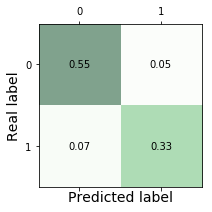

In [31]:
plot_confusion_matrix(y_train, y_train_pred)

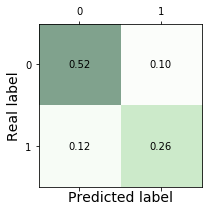

In [32]:
plot_confusion_matrix(y_test, y_test_pred)

The model seems to be overfitted

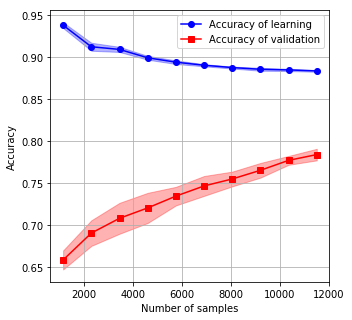

In [27]:
plot_learning_curve(estimator=stem_lr_model, X=X_train_stem_preprocessed, y=y_train)

In [61]:
importance = np.abs(stem_lr_model.coef_[0, :])
print_kbest(stem_pipe, importance, 10, X_train)

Feature: gay                  Score:    7.448	Count:    393
Feature: fuck                 Score:    6.785	Count:   1500
Feature: bitch                Score:    6.213	Count:    485
Feature: emo                  Score:    4.420	Count:    123
Feature: damn                 Score:    4.392	Count:   1599
Feature: hate                 Score:    4.191	Count:   1735
Feature: whore                Score:    4.191	Count:    122
Feature: ass                  Score:    3.919	Count:   1168
Feature: loser                Score:    3.816	Count:    112
Feature: fat                  Score:    3.256	Count:    351


In [35]:
# lemmatization
lem_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='lem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler())
    ])

In [36]:
X_train_lem_preprocessed = lem_pipe.fit_transform(X_train)
X_test_lem_preprocessed = lem_pipe.transform(X_test)

In [37]:
lem_lr_model = LogisticRegression(penalty='l2', C=1.0)
lem_lr_model.fit(X_train_lem_preprocessed, y_train);

y_train_pred = lem_lr_model.predict(X_train_lem_preprocessed)
y_test_pred = lem_lr_model.predict(X_test_lem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.886
Test dataset: accuracy = 0.786


In [38]:
y_train_proba = lem_lr_model.predict_proba(X_train_lem_preprocessed)[:, 1]
y_test_proba = lem_lr_model.predict_proba(X_test_lem_preprocessed)[:, 1]
print('Tarining dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: roc_auc = 0.954
Test dataset: roc_auc = 0.862


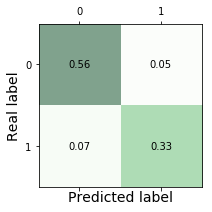

In [39]:
plot_confusion_matrix(y_train, y_train_pred)

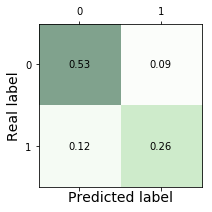

In [40]:
plot_confusion_matrix(y_test, y_test_pred)

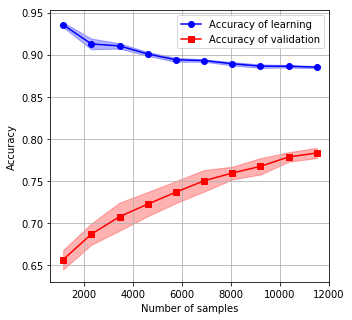

In [34]:
plot_learning_curve(estimator=lem_lr_model, X=X_train_lem_preprocessed, y=y_train)

In [67]:
importance = np.abs(lem_lr_model.coef_[0, :])
print_kbest(lem_pipe, importance, 10, X_train)

Feature: gay                  Score:    7.078	Count:    388
Feature: fuck                 Score:    6.883	Count:    938
Feature: bitch                Score:    6.031	Count:    470
Feature: emo                  Score:    4.212	Count:    120
Feature: whore                Score:    4.016	Count:    122
Feature: damn                 Score:    4.008	Count:   1599
Feature: as                   Score:    3.811	Count:   1466
Feature: hate                 Score:    3.800	Count:   1710
Feature: loser                Score:    3.578	Count:    111
Feature: fucking              Score:    3.551	Count:    601


### RandomForestClassifier

In [43]:
# stemming
stem_rfc_model = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=1000)

stem_rfc_model.fit(X_train_stem_preprocessed, y_train);

y_train_pred = stem_rfc_model.predict(X_train_stem_preprocessed)
y_test_pred = stem_rfc_model.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.862
Test dataset: accuracy = 0.779


In [44]:
y_train_proba = stem_rfc_model.predict_proba(X_train_stem_preprocessed)[:, 1]
y_test_proba = stem_rfc_model.predict_proba(X_test_stem_preprocessed)[:, 1]
print('Tarining dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: roc_auc = 0.958
Test dataset: roc_auc = 0.877


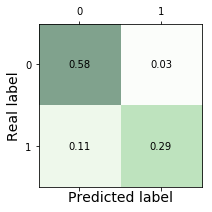

In [45]:
plot_confusion_matrix(y_train, y_train_pred)

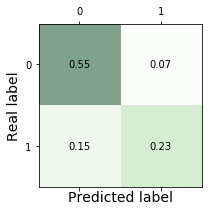

In [46]:
plot_confusion_matrix(y_test, y_test_pred)

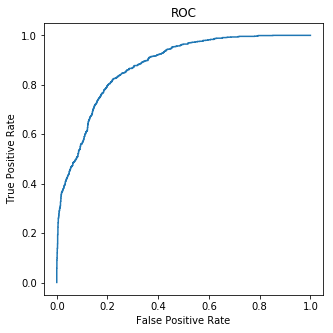

In [47]:
plot_roc_curve(y_labels=y_test, y_proba=y_test_proba)

In [48]:
fprs, tprs, thresholds = roc_curve(y_true=y_test, y_score=y_test_proba)
ind = np.argmax(tprs >= 0.75)

print('FPR: %.3f' % fprs[ind])
print('TPR: %.3f' % tprs[ind])
threshold = thresholds[ind]
print('Threshold: %.3f' % threshold)

FPR: 0.171
TPR: 0.751
Threshold: 0.440


In [49]:
y_test_pred_new_threshold = np.where(y_test_proba >= threshold, 1, 0)
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred_new_threshold, y_true=y_test))

Test dataset: accuracy = 0.799


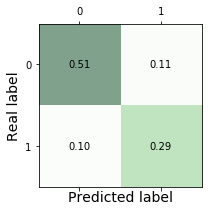

In [50]:
plot_confusion_matrix(y_test, y_test_pred_new_threshold)

In [68]:
print_kbest(stem_pipe, stem_rfc_model.feature_importances_, 10, X_train)

Feature: fuck                 Score:    0.091	Count:   1500
Feature: onequestionmark      Score:    0.041	Count:   2937
Feature: VERB_r               Score:    0.036	Count:  10858
Feature: ass                  Score:    0.035	Count:   1168
Feature: bitch                Score:    0.034	Count:    485
Feature: NOUN_r               Score:    0.030	Count:  12175
Feature: uppercase_r          Score:    0.028	Count:   2137
Feature: ._r                  Score:    0.027	Count:  11267
Feature: PRON_r               Score:    0.026	Count:   9244
Feature: gay                  Score:    0.025	Count:    393


In [69]:
# lemmatization
lem_rfc_model = RandomForestClassifier(n_estimators=100, max_depth=15, max_features=1000)
lem_rfc_model.fit(X_train_stem_preprocessed, y_train);

y_train_pred = lem_rfc_model.predict(X_train_stem_preprocessed)
y_test_pred = lem_rfc_model.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.854
Test dataset: accuracy = 0.776


In [70]:
y_train_proba = lem_rfc_model.predict_proba(X_train_stem_preprocessed)[:, 1]
y_test_proba = lem_rfc_model.predict_proba(X_test_stem_preprocessed)[:, 1]
print('Tarining dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_train_proba, y_true=y_train))
print('Test dataset: roc_auc = %.3f' % roc_auc_score(y_score=y_test_proba, y_true=y_test))

Tarining dataset: roc_auc = 0.957
Test dataset: roc_auc = 0.878


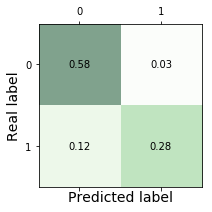

In [71]:
plot_confusion_matrix(y_train, y_train_pred)

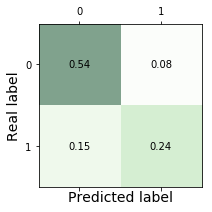

In [72]:
plot_confusion_matrix(y_test, y_test_pred)

In [73]:
print_kbest(lem_pipe, lem_rfc_model.feature_importances_, 10, X_train)

Feature: floor                Score:    0.094	Count:     16
Feature: neat                 Score:    0.039	Count:      7
Feature: art                  Score:    0.037	Count:     10
Feature: VERB_r               Score:    0.035	Count:  10858
Feature: bien                 Score:    0.034	Count:      2
Feature: NOUN_r               Score:    0.030	Count:  12175
Feature: uppercase_r          Score:    0.028	Count:   2137
Feature: ._r                  Score:    0.028	Count:  11267
Feature: frann                Score:    0.027	Count:      2
Feature: PRON_r               Score:    0.026	Count:   9244


## Feature selection

### ANOVA

In [12]:
from sklearn.feature_selection import f_classif, SelectFpr

In [75]:
fpr_stem_selector = SelectFpr(score_func=f_classif, alpha=0.01)
fpr_stem_dtm = fpr_stem_selector.fit_transform(X_train_stem_preprocessed, y_train)
fpr_stem_dtm.shape

(12776, 279)

In [76]:
fpr_lem_selector = SelectFpr(score_func=f_classif, alpha=0.01)
fpr_lem_dtm = fpr_lem_selector.fit_transform(X_train_lem_preprocessed, y_train)
fpr_lem_dtm.shape

(12776, 280)

In [78]:
print_kbest(stem_pipe, fpr_stem_selector.scores_, 10, X_train)

Feature: fuck                 Score:  564.091	Count:   1500
Feature: onequestionmark      Score:  211.210	Count:   2937
Feature: ass                  Score:  200.388	Count:   1168
Feature: bitch                Score:  186.842	Count:    485
Feature: gay                  Score:  112.768	Count:    393
Feature: uppercase_r          Score:   91.561	Count:   2137
Feature: ever                 Score:   91.526	Count:    230
Feature: emo                  Score:   86.940	Count:    123
Feature: what                 Score:   80.985	Count:    988
Feature: oneexclamationmark   Score:   77.777	Count:   2762


In [79]:
print_kbest(lem_pipe, fpr_lem_selector.scores_, 10, X_train)

Feature: fuck                 Score:  416.894	Count:    938
Feature: onequestionmark      Score:  211.210	Count:   2937
Feature: bitch                Score:  186.877	Count:    470
Feature: as                   Score:  151.504	Count:   1466
Feature: fucking              Score:  141.047	Count:    601
Feature: gay                  Score:  114.922	Count:    388
Feature: uppercase_r          Score:   91.561	Count:   2137
Feature: ever                 Score:   91.526	Count:    230
Feature: emo                  Score:   82.782	Count:    120
Feature: oneexclamationmark   Score:   77.777	Count:   2762


In [80]:
sorted_features = get_sorted_features(stem_pipe, fpr_stem_selector.scores_)
print(sorted_features[:fpr_stem_dtm.shape[1]])

['fuck' 'onequestionmark' 'ass' 'bitch' 'gay' 'uppercase_r' 'ever' 'emo'
 'what' 'oneexclamationmark' 'emoticonhappyfac' 'shit' 'onedot' 'do'
 'that' 'favorit' 'firstcapital_r' 'hate' 'suck' 'repeatingletters_r' 'ur'
 'loser' 'cunt' 'whore' 'manydot' 'haha' 'nope' 'would' "you'r" 'im' 'hi'
 'cock' 'holi' 'CONJ_r' "i'm" 'fat' 'question' 'she' 'up' 'nigga' 'ugli'
 'yeah' 'dude' 'wow' 'dick' 'face' 'quotationmark' 'idk' 'dam' 'ADJ_r'
 'stupid' 'he' 'have' 'love' 'guy' 'slut' 'man' 'pussi' 'off' 'think'
 'ADV_r' 'over' 'win' 'NUM_r' 'kj' 'earli' 'goddamn' 'mean' 'damn' 'gonna'
 'put' 'him' 'ye' 'shut' 'person' 'just' 'screen' 'bull' 'PRT_r' 'and'
 'one' 'award' 'choke' 'son' 'fag' 'shorti' 'retard' 'ive' 'prepar' 'down'
 'call' 'season' 'mani' 'nerd' 'said' 'block' 'bhut' 'sens' 'lick' 'umm'
 'action' 'marc' 'rather' 'yew' 'best' 'mess' 'final' 'yo' 'yuh' 'teas'
 'fool' 'red' 'hell' 'dont' 'matur' 'coulda' 'cart' 'subject' 'fucker'
 'messag' 'VERB_r' 'angri' 'nomin' 'got' 'wtf' 'poor' 'blo

In [81]:
sorted_features = get_sorted_features(lem_pipe, fpr_lem_selector.scores_)
print(sorted_features[:fpr_lem_dtm.shape[1]])

['fuck' 'onequestionmark' 'bitch' 'as' 'fucking' 'gay' 'uppercase_r'
 'ever' 'emo' 'oneexclamationmark' 'emoticonhappyface' 'shit' 'onedot'
 'what' 'that' 'favorite' 'firstcapital_r' 'do' 'hate'
 'repeatingletters_r' 'suck' 'his' 'ur' 'loser' 'cunt' 'whore' 'manydots'
 'haha' 'cock' 'would' 'nope' 'im' "you're" 'holy' 'sucks' 'fat' 'up'
 'CONJ_r' "i'm" 'question' 'she' 'yeah' 'dude' 'ugly' 'dick' 'face' 'wow'
 "what's" 'quotationmark' 'stupid' 'nigga' 'idk' 'dam' 'ADJ_r' 'mean'
 'lick' 'have' 'man' 'guy' 'off' 'over' 'think' 'slut' 'ADV_r' 'pussy'
 'win' 'NUM_r' 'kj' 'goddamn' 'damn' 'retard' 'gonna' 'put' 'love' 'him'
 'he' 'shut' 'just' 'bull' 'PRT_r' 'and' 'award' 'thanks' 'yes' 'hat'
 'choke' 'one' 'early' 'son' 'fag' 'shorty' 'say' 'ive' 'celebrate'
 'prepare' 'down' 'call' 'many' 'block' 'bhut' 'get' 'umm' 'action'
 'fucker' 'marc' 'rather' 'yew' 'best' 'nerd' 'mess' 'yuh' 'tease' 'fool'
 'red' 'hell' 'dont' 'keep' 'coulda' 'appearance' 'lifes' 'mature' 'cart'
 'blow' 'VERB_r' 'a

In [82]:
fpr_stem_pipe = Pipeline([
    ('selector', SelectFpr(score_func=f_classif, alpha=0.01)),
    ('clf', LogisticRegression(penalty='l2', C=1.0))
    ])

In [83]:
fpr_stem_pipe.fit(X_train_stem_preprocessed, y_train);

y_train_pred = fpr_stem_pipe.predict(X_train_stem_preprocessed)
y_test_pred = fpr_stem_pipe.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.735
Test dataset: accuracy = 0.716


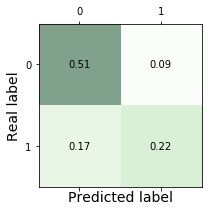

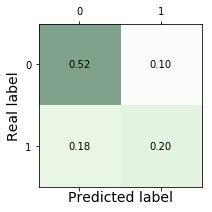

In [84]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [85]:
fpr_stem_pipe = Pipeline([
    ('selector', SelectFpr(score_func=f_classif, alpha=0.01)),
    ('clf', LogisticRegression(penalty='l2', C=1.0, class_weight={0: 1, 1: 1.25}))
    ])

fpr_stem_pipe.fit(X_train_stem_preprocessed, y_train);

y_train_pred = fpr_stem_pipe.predict(X_train_stem_preprocessed)
y_test_pred = fpr_stem_pipe.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.736
Test dataset: accuracy = 0.721


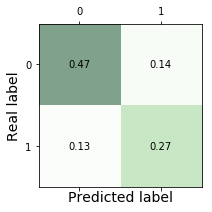

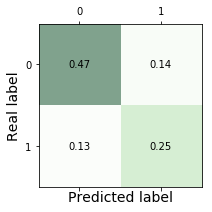

In [86]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

### Variance

In [13]:
from sklearn.feature_selection import VarianceThreshold

In [88]:
vr_stem_selector = VarianceThreshold(threshold=10e-4)
vr_stem_dtm = vr_stem_selector.fit_transform(X_train_stem_preprocessed, y_train)
vr_stem_dtm.shape

(12776, 793)

In [89]:
vr_lem_selector = VarianceThreshold(threshold=10e-4)
vr_lem_dtm = vr_lem_selector.fit_transform(X_train_lem_preprocessed, y_train)
vr_lem_dtm.shape

(12776, 752)

In [90]:
print_kbest(stem_pipe, vr_stem_selector.variances_, 10, X_train)

Feature: NOUN_r               Score:    0.033	Count:  12175
Feature: firstcapital_r       Score:    0.024	Count:   6807
Feature: what                 Score:    0.019	Count:    988
Feature: suck                 Score:    0.019	Count:   1026
Feature: PRON_r               Score:    0.018	Count:   9244
Feature: uppercase_r          Score:    0.017	Count:   2137
Feature: ._r                  Score:    0.017	Count:  11267
Feature: just                 Score:    0.016	Count:    769
Feature: ADP_r                Score:    0.015	Count:   7174
Feature: that                 Score:    0.015	Count:   2582


In [91]:
print_kbest(lem_pipe, vr_lem_selector.variances_, 10, X_train)

Feature: NOUN_r               Score:    0.033	Count:  12175
Feature: firstcapital_r       Score:    0.024	Count:   6807
Feature: that                 Score:    0.023	Count:   2263
Feature: sucks                Score:    0.018	Count:    963
Feature: PRON_r               Score:    0.018	Count:   9244
Feature: uppercase_r          Score:    0.017	Count:   2137
Feature: ._r                  Score:    0.017	Count:  11267
Feature: what                 Score:    0.017	Count:    837
Feature: just                 Score:    0.016	Count:    769
Feature: ADP_r                Score:    0.015	Count:   7174


In [92]:
sorted_features = get_sorted_features(stem_pipe, vr_stem_selector.variances_)
print(sorted_features[:vr_stem_dtm.shape[1]][:200])

['NOUN_r' 'firstcapital_r' 'what' 'suck' 'PRON_r' 'uppercase_r' '._r'
 'just' 'ADP_r' 'that' 'hope' 'take' 'CONJ_r' 'it' 'in' 'though' 'up'
 'VERB_r' 'at' 'onedot' 'do' 'ass' "don't" 'gonna' "i'v" 'think' 'have'
 'hate' 'wish' 'is' 'keep' 'manydot' 'lol' 'want' 'fuck' 'first' 'make'
 'and' 'anyth' 'actual' 'good' 'also' 'awesom' 'ADV_r' 'get' 'play' "i'm"
 'cool' 'sometim' 'caus' 'realli' 'well' 'got' 'alreadi' 'next' 'off' 'am'
 'aw' 'hell' 'emoticonsadfac' 'find' 'hi' 'PRT_r' 'thing' 'see'
 'emoticonhappyfac' 'ADJ_r' 'face' 'work' 'real' 'day' 'know' 'leav' 'thi'
 'go' 'an' 'nope' 'look' 'need' 'man' 'right' 'soon' 'crazi' 'would'
 'repeatingletters_r' 'are' "you'r" 'laugh' 'ur' 'still' 'believ' 'DET_r'
 'like' 'ugh' 'yea' 'shit' 'one' 'might' 'use' 'probabl' 'wonder' 'damn'
 'ever' 'love' 'agre' 'boy' 'saw' 'guy' 'way' 'thank' 'enough' 'btw'
 'dont' 'cunt' 'either' 'even' 'manyquestionmark' 'kick' 'heard' 'ah'
 'late' 'rock' 'could' 'peopl' 'come' 'mean' "we'r" 'son' 'feel' 'hm'
 't

In [93]:
sorted_features = get_sorted_features(lem_pipe, vr_lem_selector.variances_)
print(sorted_features[:vr_lem_dtm.shape[1]][:200])

['NOUN_r' 'firstcapital_r' 'that' 'sucks' 'PRON_r' 'uppercase_r' '._r'
 'what' 'just' 'ADP_r' 'CONJ_r' 'it' 'in' 'though' 'hope' 'up' 'think'
 'VERB_r' 'do' 'at' 'onedot' "don't" 'gonna' 'get' "i've" 'make' 'good'
 'have' 'keep' "what's" 'wish' 'find' 'hate' 'is' 'manydots' 'lol' 'want'
 'first' 'and' 'anything' 'cool' 'well' 'also' 'see' 'awesome' 'ADV_r'
 'actually' "i'm" 'play' 'cause' 'really' 'next' 'already' 'off' 'kind'
 'hell' 'am' 'emoticonsadface' 'go' 'PRT_r' 'thing' 'totally' 'sometimes'
 'know' 'emoticonhappyface' 'ADJ_r' 'work' 'face' 'his' 'real' 'day'
 'fucking' 'this' 'as' 'an' 'right' 'need' 'soon' 'man' 'look' 'would'
 'repeatingletters_r' 'crazy' 'nope' 'are' "you're" 'bad' 'laugh' 'ur'
 'suck' 'aw' 'still' 'believe' 'DET_r' 'tell' 'ugh' 'like' 'come' "that's"
 'fuck' 'yea' 'forget' 'might' 'one' 'mean' 'use' 'damn' 'ever' 'say'
 'shit' 'boy' 'wonder' 'probably' 'agree' 'saw' 'way' 'guy' 'take' 'love'
 'enough' 'btw' 'he' 'dont' 'either' 'video' 'cunt' 'manyquestion

In [94]:
vr_stem_pipe = Pipeline([
    ('selector', VarianceThreshold(threshold=10e-4)),
    ('clf', LogisticRegression(penalty='l2', C=1.0, class_weight={0: 1, 1: 1.15}))
    ])

vr_stem_pipe.fit(X_train_stem_preprocessed, y_train);

y_train_pred = vr_stem_pipe.predict(X_train_stem_preprocessed)
y_test_pred = vr_stem_pipe.predict(X_test_stem_preprocessed)

print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.754
Test dataset: accuracy = 0.722


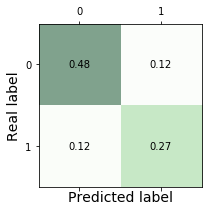

In [95]:
plot_confusion_matrix(y_train, y_train_pred)

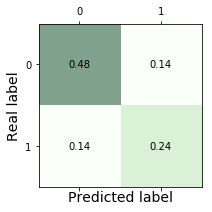

In [96]:
plot_confusion_matrix(y_test, y_test_pred)

## Hyperparameter Tuning

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer

from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import scipy
from scipy.spatial.distance import cosine
from pprint import pprint
from sklearn.base import clone

### Number of features

#### Feature selection - CountVectorizer

In [15]:
def count_features(pipe_trans, param_range, param_name, process):
    pipe = clone(pipe_trans)
    no_features = []
    for param in param_range:
        pipe.set_params(**{'preprocessor__process': process, param_name: param})
        dtm = pipe.fit_transform(X_train)
        no_features.append(dtm.shape[1])
    return no_features

def plot_no_features(pipe_trans, param_range, param_name, process):    
    no_features = count_features(pipe_trans, param_range, param_name, process)
    
    fig, ax = plt.subplots(figsize=(5, 5))    
    ax.plot(param_range, no_features, '--o')
    ax.set_xlabel(param_name)
    ax.set_ylabel('Number of features')
    ax.set_title('Process = ' + process)
    ax.grid()
    plt.show()    

In [73]:
tf_pipe = Pipeline([('preprocessor', TextPreprocessor()),
                    ('vectorizer', CountVectorizer(token_pattern=token_pattern))
                   ])

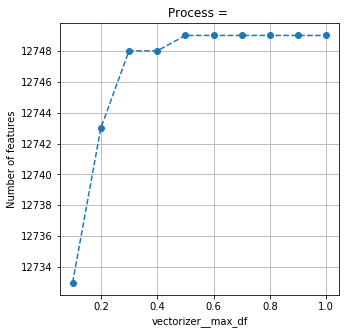

In [95]:
max_df_range = np.arange(0.1, 1.1, 0.1)
process = ''
param_name = 'vectorizer__max_df'
plot_no_features(tf_pipe, max_df_range, param_name, process)

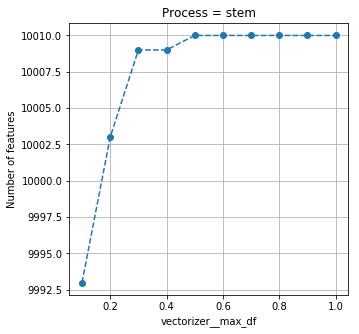

In [96]:
max_df_range = np.arange(0.1, 1.1, 0.1)
process = 'stem'
param_name = 'vectorizer__max_df'
plot_no_features(tf_pipe, max_df_range, param_name, process)

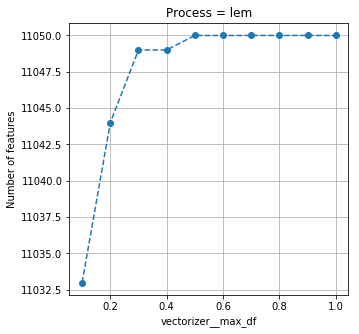

In [97]:
max_df_range = np.arange(0.1, 1.1, 0.1)
process = 'lem'
param_name = 'vectorizer__max_df'
plot_no_features(tf_pipe, max_df_range, param_name, process)

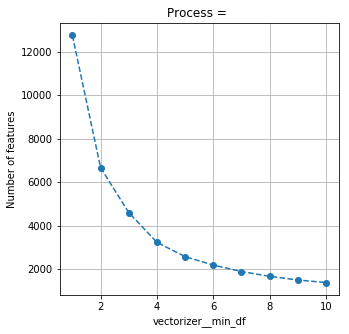

In [98]:
min_df_range = np.arange(1, 11, 1)
process = ''
param_name = 'vectorizer__min_df'
plot_no_features(tf_pipe, min_df_range, param_name, process)

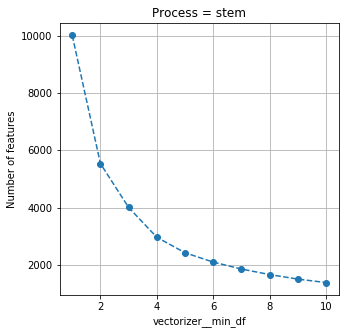

In [99]:
min_df_range = np.arange(1, 11, 1)
process = 'stem'
param_name = 'vectorizer__min_df'
plot_no_features(tf_pipe, min_df_range, param_name, process)

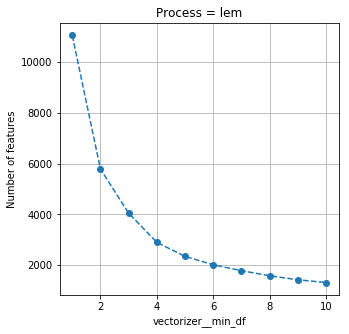

In [100]:
min_df_range = np.arange(1, 11, 1)
process = 'lem'
param_name = 'vectorizer__min_df'
plot_no_features(tf_pipe, min_df_range, param_name, process)

In [101]:
ngram_range = [(1, 1), (1, 2), (2, 2), (1, 3)]
process = ''
param_name = 'vectorizer__ngram_range'
count_features(tf_pipe, ngram_range, param_name, process)

[12749, 81774, 69025, 187067]

In [102]:
ngram_range = [(1, 1), (1, 2), (2, 2), (1, 3)]
process = 'stem'
param_name = 'vectorizer__ngram_range'
count_features(tf_pipe, ngram_range, param_name, process)

[10010, 75284, 65274, 179641]

In [103]:
ngram_range = [(1, 1), (1, 2), (2, 2), (1, 3)]
process = 'lem'
param_name = 'vectorizer__ngram_range'
count_features(tf_pipe, ngram_range, param_name, process)

[11050, 76978, 65928, 181506]

#### Feature extraction - SVD

In [104]:
lsi_pipe= Pipeline([('preprocessor', TextPreprocessor()),
                    ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, norm='l2')),
                    ('svd', TruncatedSVD())
                    ])

In [105]:
component_range = np.arange(100, 2000, 100)
explained_variance = []
for n in component_range:
    lsi_pipe.set_params(**{'svd__n_components': n})
    dtm = lsi_pipe.fit_transform(X_train)
    variance = lsi_pipe.named_steps['svd'].explained_variance_ratio_.sum()
    explained_variance.append(variance)

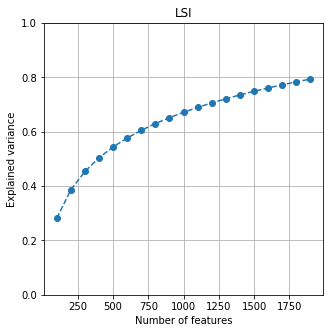

In [106]:
fig, ax = plt.subplots(figsize=(5, 5))    
ax.plot(component_range, explained_variance, '--o')
ax.set_xlabel('Number of features')
ax.set_ylabel('Explained variance')
ax.set_title('LSI')
ax.set_ylim(0, 1)
ax.grid()
plt.show()

In [107]:
lsi_pipe.set_params(**{'svd__n_components': 2})
svd_dtm = lsi_pipe.fit_transform(X_train)
print('Explained variance = %.3f' % lsi_pipe.named_steps['svd'].explained_variance_ratio_.sum())

Explained variance = 0.017


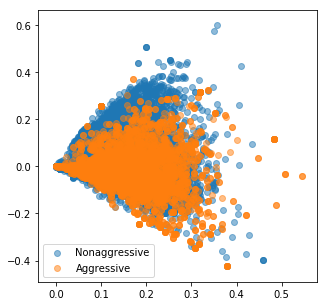

In [108]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(svd_dtm[y_train == 0, 0], svd_dtm[y_train == 0, 1], label='Nonaggressive', alpha=0.5)
ax.scatter(svd_dtm[y_train == 1, 0], svd_dtm[y_train == 1, 1], label='Aggressive', alpha=0.5)
plt.legend()
plt.show()

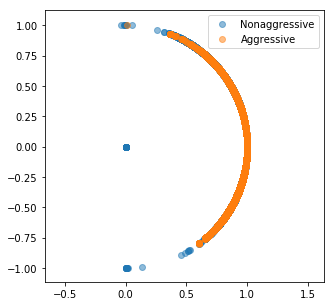

In [109]:
svd_dtm_normalized = Normalizer().fit_transform(svd_dtm)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(svd_dtm_normalized[y_train == 0, 0], svd_dtm_normalized[y_train == 0, 1], 
           label='Nonaggressive', alpha=0.5)
ax.scatter(svd_dtm_normalized[y_train == 1, 0], svd_dtm_normalized[y_train == 1, 1], 
           label='Aggressive', alpha=0.5)
plt.axis('equal')
plt.legend()
plt.show()

In [110]:
lsi_pipe = Pipeline([('preprocessor', TextPreprocessor()),
                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, norm='l2',
                                                    ngram_range=(1, 2), min_df=2)),
                     ('svd', TruncatedSVD())
                    ])

In [111]:
component_range = np.arange(100, 2000, 100)
explained_variance = []
for n in component_range:
    lsi_pipe.set_params(**{'svd__n_components': n})
    dtm = lsi_pipe.fit_transform(X_train)
    variance = lsi_pipe.named_steps['svd'].explained_variance_ratio_.sum()
    explained_variance.append(variance)

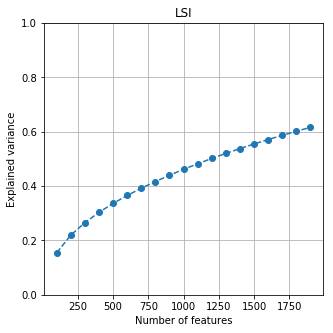

In [112]:
fig, ax = plt.subplots(figsize=(5, 5))    
ax.plot(component_range, explained_variance, '--o')
ax.set_xlabel('Number of features')
ax.set_ylabel('Explained variance')
ax.set_title('LSI')
ax.set_ylim(0, 1)
ax.grid()
plt.show()

### Transformers

#### CountVectorizer: Term Frequency

In [16]:
tf_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2)))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler())
    ])

preprocessor_path = 'transformer__features__text_feats__preprocessor'
vectorizer_path = 'transformer__features__text_feats__vectorizer'
tf_param_dist = {
                 preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
#                  preprocessor_path + '__process': ['lem', 'stem', ''],
                 vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
#                  vectorizer_path + '__min_df': randint(1, 6),
                 vectorizer_path + '__min_df': randint(15, 50),
                 }

In [15]:
tf_dtm_train = tf_pipe.fit_transform(X_train)
tf_dtm_test = tf_pipe.transform(X_test)

#### TfidfVectorizer: Term Frequency - Inverse Document Frequency

In [16]:
tfidf_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2), norm='l2'))
                                    ]))
            ]))
    ])

tfidf_param_dist = {
                    preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
#                     preprocessor_path + '__process': ['lem', 'stem', ''],
                    vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
#                     vectorizer_path + '__min_df': randint(1, 6),
                    vectorizer_path + '__min_df': randint(15, 50),
                    }

In [17]:
tfidf_dtm_train = tfidf_pipe.fit_transform(X_train)
tfidf_dtm_test = tfidf_pipe.transform(X_test)

#### SVD: Singular Value Decomposition (Latent Semantic Indexing)

In [18]:
lsi_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2), norm='l2')),
                                     ('svd', TruncatedSVD(n_components=750)),
                                     ('normalizer', Normalizer())
                                    ]))
            ]))
    ])

svd_path = 'transformer__features__text_feats__svd'
lsi_param_dist = {
#                   preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
#                   preprocessor_path + '__process': ['lem', 'stem', ''],
#                   vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
#                   vectorizer_path + '__min_df': randint(1, 6),
                  vectorizer_path + '__min_df': randint(15, 50),
                  svd_path + '__n_components': randint(100, 1000)
                  }

In [107]:
lsi_dtm_train = lsi_pipe.fit_transform(X_train)
lsi_dtm_test = lsi_pipe.transform(X_test)

In [108]:
lsi_pipe.named_steps['features'].transformer_list[1][1].named_steps['svd'].explained_variance_ratio_.sum()

0.42156796436329935

#### LatentDirichletAllocation

In [19]:
lda_pipe = Pipeline([
    ('features', FeatureUnion([
            ('freq_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', TfidfVectorizer(token_pattern=token_pattern, min_df=2,
                                                                    ngram_range=(1, 2), norm='l2')),
                                     ('lda', LatentDirichletAllocation(n_components=25, learning_method='online', 
                                                                       doc_topic_prior=0.1,
                                                                       topic_word_prior=0.1))
                                    ]))
            ]))
    ])

lda_path = 'transformer__features__text_feats__lda'
lda_param_dist = {
#                   preprocessor_path + '__stopwords': [IRRELEVANT_STOPWORDS, STOPWORDS, []],
#                   preprocessor_path + '__process': ['lem', 'stem', ''],
#                   vectorizer_path + '__ngram_range': [(1, 1), (1, 2), (2, 2)],
#                   vectorizer_path + '__min_df': randint(1, 6),
                  vectorizer_path + '__min_df': randint(15, 50),
                  lda_path + '__n_components': randint(10, 50),
                  lda_path + '__doc_topic_prior': uniform(0.01, 3 - 0.01),
                  lda_path + '__topic_word_prior': uniform(0.01, 3 - 0.01)
                  }

In [110]:
lda_dtm_train = lda_pipe.fit_transform(X_train)
lda_dtm_test = lda_pipe.transform(X_test)

In [22]:
X_train_dict = {
#                 'tf': tf_dtm_train,
#                 'tfidf': tfidf_dtm_train,
#                 'lsi': lsi_dtm_train,
#                 'lda': lda_dtm_train,
                'original': X_train
                }

X_test_dict = {
#                'tf': tf_dtm_test,
#                'tfidf': tfidf_dtm_test,
#                'lsi': lsi_dtm_test,
#                'lda': lda_dtm_test,
               'original': X_test
               }

In [143]:
# trans_name = 'tf'
# X_sparse_extended = scipy.sparse.vstack([X_train_dict[trans_name], X_test_dict[trans_name]])
# X_sparse_extended.shape

In [23]:
transformers = [('tf', tf_pipe),
                ('tfidf', tfidf_pipe),
#                 ('lsi', lsi_pipe),
#                 ('lda', lda_pipe)                
               ]

transformers_param_dist = {'tf': tf_param_dist,
                           'tfidf': tfidf_param_dist,
                           'lsi': lsi_param_dist,
                           'lda': lda_param_dist
                          }

### Estimators

In [17]:
estimators = {'lr': LogisticRegression(),
              'lin_svm': SVC(kernel='linear', probability=True),
              'rbf_svm': SVC(kernel='rbf', probability=True),
              'dt': DecisionTreeClassifier(),
              'knn': KNeighborsClassifier(),
              'nb': GaussianNB(),
              'lda': LinearDiscriminantAnalysis(),
              'qda': QuadraticDiscriminantAnalysis(),
             }

estimators_param_dist = {'lr': {'clf__penalty': ['l1', 'l2'],
                                'clf__C': uniform(0., 4.)},
                         'lin_svm': {'clf__C': uniform(0., 4.)},
                         'rbf_svm': {'clf__C': uniform(0., 4.),
                                     'clf__gamma': uniform(0.1, 3 - 0.1)},
                         'dt': {'clf__max_depth': randint(5, 15),
                                'clf__min_samples_leaf': randint(2, 40)},
                         'knn': {'clf__n_neighbors': randint(4, 15),
                                 'clf__metric': ['minkowski', cosine]},
                         'nb': {}, 
                         'lda': {},
                         'qda': {},
                        }

### Classification

In [18]:
def search_best_clfs(clf_name, X_train_dict, X_test_dict, transformation=False, n_iter=10):
    best_clfs = {}
    scores = pd.DataFrame(columns=[clf_name + '_train', clf_name + '_test'])

    for trans_name, trans_pipe in transformers:
        print(trans_name)
        if transformation:
            pipe = Pipeline([('transformer', clone(trans_pipe)),
                             ('clf', clone(estimators[clf_name]))])

            param_dist = transformers_param_dist[trans_name].copy()
            param_dist.update(estimators_param_dist[clf_name].items())
            
            X_train = X_train_dict['original']
            X_test = X_test_dict['original']
        else:
            pipe = Pipeline([('clf', clone(estimators[clf_name]))])
            param_dist = estimators_param_dist[clf_name]
            
            X_train = X_train_dict[trans_name]
            X_test = X_test_dict[trans_name]

        rs = RandomizedSearchCV(estimator=pipe, param_distributions=param_dist, 
                                n_iter=n_iter, n_jobs=-1, refit=True,
                                scoring='accuracy',
                                cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))

        rs.fit(X_train, y_train)

        best_clfs.update({trans_name: rs.best_estimator_})

        train_score = rs.score(X_train, y_train)
        test_score = rs.score(X_test, y_test)
        scores.loc[trans_name] = [train_score, test_score]
        
    return best_clfs, scores

In [19]:
def get_model_params(estimator_name, best_models_list, transformation=False):
    model_param_names = [re.search('.+__(.+?)$', k).group(1) for k in estimators_param_dist[estimator_name]]
    
    model_params = pd.DataFrame(columns=model_param_names)
    for trans_name, model in best_models_list.items():
        model_param_dict = model.named_steps['clf'].get_params()
        model_params.loc[trans_name, model_param_names] = [model_param_dict[param_name] 
                                                           for param_name in model_param_names]
        
        if transformation:
            trans_param_names = [re.search('.+__(.+?__.+?)$', k).group(1) 
                                 for k in transformers_param_dist[trans_name]]
            trans_param_dict = model.named_steps['transformer'].named_steps['features'].\
                                     transformer_list[1][1].get_params()
            for trans_param_name in trans_param_names:
                if trans_param_name not in model_params.columns:
                    model_params.loc[:, trans_param_name] = [None] * model_params.shape[0]
                model_params.loc[trans_name, trans_param_name] = trans_param_dict[trans_param_name]
        
    return model_params

In [20]:
import pickle
import os

In [21]:
def save_model(model, file_name):
    models_path = 'Models'
    if not os.path.exists(models_path):
        os.makedirs(models_path)
    
    with open(os.path.join(models_path, file_name), 'wb') as file:
        pickle.dump(model, file, protocol=4)

In [22]:
def read_model(file_name):
    with open(os.path.join('Models', file_name), 'rb') as file:
        loaded_model = pickle.load(file)
    return loaded_model

In [23]:
def save_kbest(kbest_array, file_name):
    models_path = 'kBest'
    if not os.path.exists(models_path):
        os.makedirs(models_path)

    np.savetxt(os.path.join(models_path, file_name), kbest_array, fmt='%s', delimiter=',')

#### Logistic Regression

15 <= min_df <= 50

In [107]:
clf_name = 'lr'
best_lrs, lr_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=50, transformation=True)

tf
tfidf


In [108]:
lr_scores

,lr_train,lr_test
tf,0.798137,0.752974
tfidf,0.798528,0.756105


In [109]:
get_model_params(clf_name, best_lrs, transformation=True)

,penalty,C,preprocessor__stopwords,vectorizer__ngram_range,vectorizer__min_df
tf,l1,3.08773,"[a, about, above, after, again, against, ain, ...","(1, 2)",18
tfidf,l1,1.8305,[],"(1, 2)",20


We can look at the learning and validation curve to check overfitting/underfitting

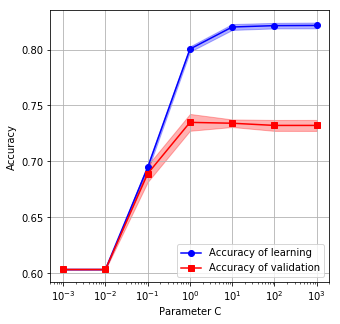

In [129]:
trans_name = 'tf'
plot_validation_curve(estimator=clone(best_lrs[trans_name]), X=X_train, y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

In [110]:
trans_name = 'tf'
lr_pipe = clone(best_lrs[trans_name])
lr_pipe.set_params(**{'clf__C': 1.})

lr_pipe.fit(X_train, y_train);

y_train_pred = lr_pipe.predict(X_train)
y_test_pred = lr_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.789
Test dataset: accuracy = 0.757


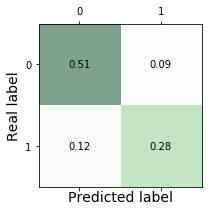

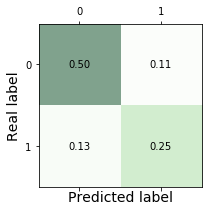

In [111]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

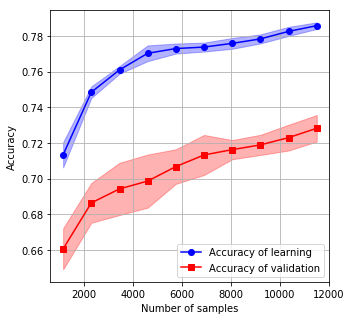

In [112]:
plot_learning_curve(estimator=clone(lr_pipe), X=X_train, y=y_train)

In [113]:
lr_pipe_extended = clone(lr_pipe)

extended_scores = cross_val_score(lr_pipe_extended, X_extended, y_extended, scoring='accuracy', 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))
print(np.round(extended_scores, 3))
print('Validation: accuracy = %.3f' % extended_scores.mean())

[0.741 0.739 0.734 0.741 0.748]
Validation: accuracy = 0.740


In [114]:
lr_pipe_extended.fit(X_extended, y_extended)
y_extended_pred = lr_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.798


In [115]:
file_name = 'logisticregression18.p'
model = lr_pipe_extended
save_model(model, file_name)

In [116]:
importance = np.abs(lr_pipe_extended.named_steps['clf'].coef_[0, :])
print_kbest(lr_pipe_extended.named_steps['transformer'], importance, 10, X_extended)

Feature: gay                  Score:   17.985	Count:    486
Feature: whore                Score:   15.285	Count:    148
Feature: fuck                 Score:    9.890	Count:   1882
Feature: bitch                Score:    8.948	Count:    609
Feature: suck                 Score:    8.328	Count:   1269
Feature: damn                 Score:    8.084	Count:   1983
Feature: emo                  Score:    6.555	Count:    151
Feature: hate                 Score:    6.326	Count:   2183
Feature: ass                  Score:    6.167	Count:   1447
Feature: pussi                Score:    5.908	Count:     64


In [117]:
sorted_features = get_sorted_features(lr_pipe_extended.named_steps['transformer'], importance)
print(sorted_features[:100])

['gay' 'whore' 'fuck' 'bitch' 'suck' 'damn' 'emo' 'hate' 'ass' 'pussi'
 'slut' 'loser' 'ugli' 'fat' 'cock' 'freak' 'fag' 'nerd' 'choke' 'love'
 'cum' 'favorit' 'onequestionmark' 'cool' 'dick' 'whale' 'pig' 'yew'
 'piss' 'laugh at' 'messag' 'cunt' 'dam' 'would do'
 'onequestionmark think' 'ever' 'thi year' 'feel better' 'umm' 'action'
 'finger' 'client' 'do oneexclamationmark' 'french' 'fli' 'screen'
 'go onedot' 'im' 'homi' 'shit onedot' 'onequestionmark are' 'club' 'lame'
 'like that' 'retard' 'bug' 'wow' 'do it' 'like fuck' 'do like' 'ive'
 'swear' 'do that' 'mi' 'realli suck' 'nope' 'manydot haha' 'poser'
 'what would' 'page' 'shit' 'hoe' 'onedot good' 'dure' 'smell'
 'gay oneexclamationmark' 'want go' 'youtub' 'manydot suck' 'bull' 'met'
 'road' 'shut fuck' 'manyexclamationmark' 'speak' 'hold'
 'fuck quotationmark' 'count' 'act' 'do onedot' 'fuck and' "don't think"
 'life' 'part' 'win' 'red' 'although' 'video' 'funni' 'parent']


In [118]:
k = 1000
file_name = 'logisticregression18' + str(k) + '.csv'
sorted_counts = get_sorted_counts(lr_pipe_extended.named_steps['transformer'], importance, X_extended)
kbest_array = np.c_[sorted_features[:k], sorted_counts[:k]]
save_kbest(kbest_array, file_name)

min_df=50

In [523]:
clf_name = 'lr'
best_lrs, lr_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=10)

tf
tfidf


In [524]:
lr_scores

,lr_train,lr_test
tf,0.741155,0.726362
tfidf,0.739277,0.727614


In [525]:
get_model_params(clf_name, best_lrs)

,penalty,C
tf,l1,2.32508
tfidf,l1,2.22329


min_df=15

In [523]:
clf_name = 'lr'
best_lrs, lr_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=10)

tf
tfidf


In [485]:
lr_scores

,lr_train,lr_test
tf,0.795085,0.751722
tfidf,0.802129,0.745773


In [493]:
get_model_params(clf_name, best_lrs)

,penalty,C
tf,l1,0.969068
tfidf,l1,2.13611


min_df=2

In [129]:
clf_name = 'lr'
best_lrs, lr_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=10)

tf
tfidf


In [91]:
lr_scores

,lr_train,lr_test
tf,0.983250,0.878835
tfidf,0.944271,0.823732
lsi,0.781935,0.744208
lda,0.718378,0.677207


In [151]:
# best_lrs['lsi'].named_steps['transformer'].named_steps['svd'].explained_variance_ratio_.sum()

In [130]:
lr_scores

,lr_train,lr_test
tf,0.989120,0.886662
tfidf,0.948889,0.828115


In [131]:
get_model_params(clf_name, best_lrs)

,penalty,C
tf,l2,3.77189
tfidf,l2,2.34047


In [92]:
# for name, model in best_lrs.items():
#     file_name = name + '_logisticregression.p'
#     save_model(model, file_name)

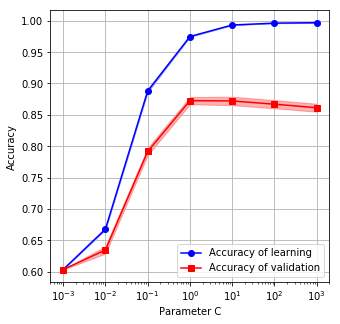

In [132]:
trans_name = 'tf'
plot_validation_curve(estimator=clone(best_lrs[trans_name]), X=X_train_dict[trans_name], y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

In [142]:
trans_name = 'tf'
lr_pipe = clone(best_lrs[trans_name])
lr_pipe.set_params(**{'clf__C': 0.9})

lr_pipe.fit(X_train_dict[trans_name], y_train);

y_train_pred = lr_pipe.predict(X_train_dict[trans_name])
y_test_pred = lr_pipe.predict(X_test_dict[trans_name])
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.972
Test dataset: accuracy = 0.869


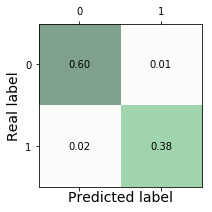

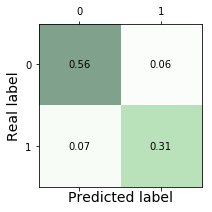

In [143]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

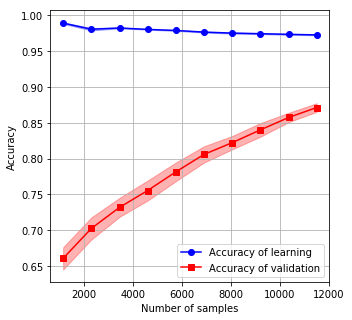

In [141]:
plot_learning_curve(estimator=clone(lr_pipe), X=X_train_dict[trans_name], y=y_train)

In [144]:
lr_pipe_extended = Pipeline([('transformer', clone(tf_pipe)),
                             ('clf', clone(lr_pipe.named_steps['clf']))])

extended_scores = cross_val_score(lr_pipe_extended, X_extended, y_extended, scoring='accuracy', 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10))
print(np.round(extended_scores, 3))
print('Validation: accuracy = %.3f' % extended_scores.mean())

[0.864 0.86  0.86  0.871 0.857]
Validation: accuracy = 0.862


In [145]:
lr_pipe_extended.fit(X_extended, y_extended)
y_extended_pred = lr_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.976


In [146]:
file_name = 'logisticregression2.p'
model = lr_pipe_extended
save_model(model, file_name)

In [150]:
# importance = np.abs(lr_pipe_extended.named_steps['clf'].coef_[0, :])
# print_kbest(lr_pipe_extended.named_steps['transformer'], importance, 10, X_extended)

In [151]:
# sorted_features = get_sorted_features(lr_pipe_extended.named_steps['transformer'], importance)
# print(sorted_features[:100])

In [150]:
# k = 1000
# file_name = 'logisticregression2' + str(k) + '.csv'
# sorted_counts = get_sorted_counts(lr_pipe_extended.named_steps['transformer'], importance, X_extended)
# kbest_array = np.c_[sorted_features[:k], sorted_counts[:k]]
# save_kbest(kbest_array, file_name)

In [129]:
clf_name = 'lr'
lr_clf = estimators[clf_name]

lr_select_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern,
                                                                    ngram_range=(1, 2), min_df=2))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler()),
    ('selector', SelectFpr(score_func=f_classif)),
    ('clf', lr_clf)
])

param_dist = {'clf__penalty': ['l1', 'l2'],
              'clf__C': uniform(0., 4.),
              'selector__alpha': uniform(0.01, 0.05)
             }

lr_select_rs = RandomizedSearchCV(estimator=lr_select_pipe, param_distributions=param_dist, 
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=20), 
                                   scoring='accuracy', n_iter=30,
                                   n_jobs=-1, refit=True)

In [130]:
lr_select_rs.fit(X_train, y_train);
lr_select_rs.best_score_

0.7556355666875392

In [131]:
lr_select_rs.best_params_

{'clf__C': 1.7274098664169002,
 'clf__penalty': 'l1',
 'selector__alpha': 0.04998936824543651}

In [133]:
best_lr_select = lr_select_rs.best_estimator_

In [135]:
y_train_pred = best_lr_select.predict(X_train)
y_test_pred = best_lr_select.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.892
Test dataset: accuracy = 0.791


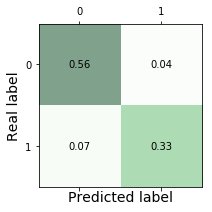

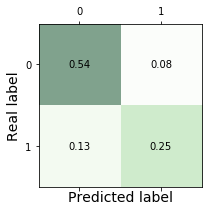

In [136]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [168]:
lr_pipe = clone(best_lr_select)
lr_pipe.set_params(**{'clf__class_weight': {0: 1, 1: 1.1},
                      'clf__C': 0.5,
#                       'selector__alpha': 0.1
                      })

lr_pipe.fit(X_train, y_train)

y_train_pred = lr_pipe.predict(X_train)
y_test_pred = lr_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.810
Test dataset: accuracy = 0.759


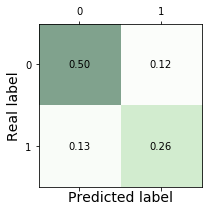

In [169]:
plot_confusion_matrix(y_test, y_test_pred)

In [170]:
lr_pipe_extended = clone(lr_pipe)
lr_pipe_extended.fit(X_extended, y_extended);
y_extended_pred = lr_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.826


In [171]:
file_name = 'lrselect.p'
model = lr_pipe_extended
save_model(model, file_name)

#### Linear SVM

In [ ]:
# clf_name = 'lin_svm'
# best_lin_svms, lin_svm_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=30, transformation=True)

#### SVM with kernel RBF

15 <= min_df <= 50

In [30]:
clf_name = 'rbf_svm'
best_rbf_svms, rbf_svm_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=30, transformation=True)

tf
tfidf


In [31]:
rbf_svm_scores

,rbf_svm_train,rbf_svm_test
tf,0.990294,0.927990
tfidf,0.997574,0.937696


In [32]:
get_model_params(clf_name, best_rbf_svms, transformation=True)

,C,gamma,preprocessor__stopwords,vectorizer__ngram_range,vectorizer__min_df
tf,1.38106,2.20679,[],"(1, 1)",32
tfidf,2.45173,2.72007,"[a, about, above, after, again, against, ain, ...","(1, 2)",18


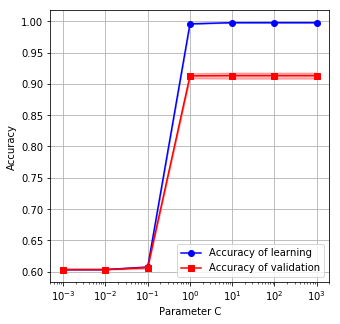

In [34]:
trans_name = 'tfidf'
plot_validation_curve(estimator=clone(best_rbf_svms[trans_name]), X=X_train, y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

In [ ]:
# trans_name = 'tfidf'
# plot_validation_curve(estimator=clone(best_rbf_svms[trans_name]), X=X_train, y=y_train, 
#                       param_name='clf__gamma', param_range=np.linspace(0.5, 3.5, 7), x_scale='linear')

In [90]:
rbf_svm_pipe = clone(best_rbf_svms[trans_name])
rbf_svm_pipe.set_params(**{'clf__C': 0.9})

rbf_svm_pipe.fit(X_train, y_train);

y_train_pred = rbf_svm_pipe.predict(X_train)
y_test_pred = rbf_svm_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.996
Test dataset: accuracy = 0.935


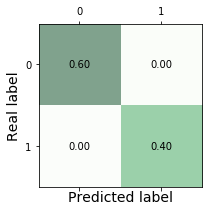

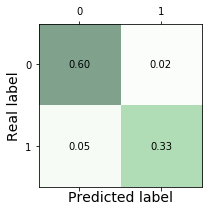

In [91]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [39]:
rbf_svm_pipe_extended = clone(best_rbf_svms[trans_name])

extended_scores = cross_val_score(rbf_svm_pipe_extended, X_extended, y_extended, scoring='accuracy', 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), n_jobs=-1)
print(np.round(extended_scores, 3))
print('Validation: accuracy = %.3f' % extended_scores.mean())

[0.932 0.929 0.934 0.94  0.931]
Validation: accuracy = 0.933


In [40]:
rbf_svm_pipe_extended.fit(X_extended, y_extended)
y_extended_pred = rbf_svm_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.997


In [42]:
file_name = 'rbfsvm18.p'
model = rbf_svm_pipe_extended
save_model(model, file_name)

min_df=2

In [ ]:
clf_name = 'rbf_svm'
best_rbf_svms, rbf_svm_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=10)

In [155]:
rbf_svm_scores

,rbf_svm_train,rbf_svm_test
tf,0.997652,0.937696
tfidf,0.995069,0.910457


In [106]:
get_model_params(clf_name, best_rbf_svms)

,C,gamma
tf,3.8464,1.99861
tfidf,3.1741,0.460031


In [156]:
# for name, model in best_rbf_svms.items():
#     file_name = name + '_rbfsvm.p'
#     save_model(model, file_name)

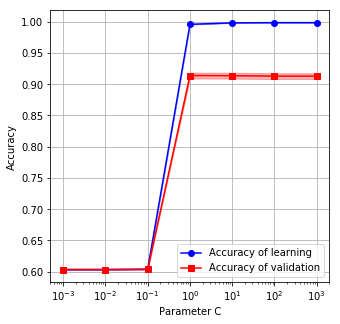

In [167]:
trans_name = 'tf'
plot_validation_curve(estimator=clone(best_rbf_svms[trans_name]), X=X_train_dict[trans_name], y=y_train, 
                      param_name='clf__C', param_range=np.logspace(-3, 3, 7), x_scale='log')

In [159]:
trans_name = 'tf'
rbf_svm_pipe = clone(best_rbf_svms[trans_name])
rbf_svm_pipe.set_params(**{'clf__C': 0.8})

rbf_svm_pipe.fit(X_train_dict[trans_name], y_train);

y_train_pred = rbf_svm_pipe.predict(X_train_dict[trans_name])
y_test_pred = rbf_svm_pipe.predict(X_test_dict[trans_name])
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.996
Test dataset: accuracy = 0.936


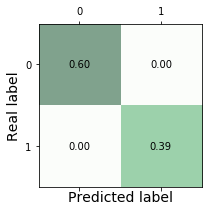

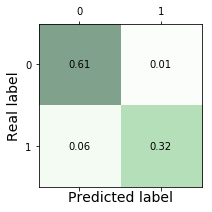

In [160]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [161]:
# trans_name = 'tf'
# plot_validation_curve(estimator=clone(best_rbf_svms[trans_name]), X=X_train_dict[trans_name], y=y_train, 
#                       param_name='clf__gamma', param_range=np.linspace(0.5, 3.5, 7), x_scale='linear')

In [ ]:
# trans_name = 'tf'
# rbf_svm_pipe = clone(best_rbf_svms[trans_name])
# rbf_svm_pipe.set_params(**{'clf__gamma': 1.})

# rbf_svm_pipe.fit(X_train_dict[trans_name], y_train);

# y_train_pred = rbf_svm_pipe.predict(X_train_dict[trans_name])
# y_test_pred = rbf_svm_pipe.predict(X_test_dict[trans_name])
# print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
# print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

In [ ]:
# plot_learning_curve(estimator=clone(best_rbf_svms[trans_name]), X=X_train_dict[trans_name], y=y_train)

In [164]:
rbf_svm_pipe_extended = Pipeline([('transformer', clone(tf_pipe)),
                                  ('clf', clone(best_rbf_svms[trans_name]))])

extended_scores = cross_val_score(rbf_svm_pipe_extended, X_extended, y_extended, scoring='accuracy', 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), n_jobs=-1)
print(np.round(extended_scores, 3))
print('Validation: accuracy = %.3f' % extended_scores.mean())

[0.935 0.93  0.932 0.94  0.928]
Validation: accuracy = 0.933


In [165]:
rbf_svm_pipe_extended.fit(X_extended, y_extended)
y_extended_pred = rbf_svm_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.997


In [166]:
file_name = 'rbfsvm2.p'
model = rbf_svm_pipe_extended
save_model(model, file_name)

#### Decision Tree

In [ ]:
# clf_name = 'dt'
# best_dts, dt_scores = search_best_clfs(clf_name, X_train_dict, X_test_dict, n_iter=10)

In [37]:
trans_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern,
                                                                    ngram_range=(1, 2), min_df=15))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler())
])

In [38]:
X_train_preprocessed = trans_pipe.fit_transform(X_train)
X_test_preprocessed = trans_pipe.transform(X_test)

In [39]:
X_train_preprocessed = X_train_preprocessed.toarray()
X_test_preprocessed = X_test_preprocessed.toarray()

#### K-Nearest Neighbors

In [51]:
clf_name = 'knn'
knn = Pipeline([('clf', estimators[clf_name])])

In [58]:
knn_rs = RandomizedSearchCV(estimator=knn, param_distributions=estimators_param_dist[clf_name], 
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=20), 
                            scoring='accuracy', n_iter=10,
                            n_jobs=-1, refit=True)

In [60]:
# knn_rs.fit(X_train_preprocessed, y_train);
# knn_rs.best_score_

In [ ]:
# knn_rs.best_params_

In [ ]:
# y_train_pred = knn_rs.score(X_train_preprocessed)
# y_test_pred = knn_rs.score(X_test_preprocessed)
# print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
# print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

#### Naive Bayes

In [40]:
clf_name = 'nb'
nb = estimators[clf_name]

In [41]:
nb.fit(X_train_preprocessed, y_train);

y_train_pred = nb.predict(X_train_preprocessed)
y_test_pred = nb.predict(X_test_preprocessed)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.714
Test dataset: accuracy = 0.673


#### Linear Discriminant Analysis

In [42]:
clf_name = 'lda'
lda = estimators[clf_name]

In [43]:
lda.fit(X_train_preprocessed, y_train);

y_train_pred = lda.predict(X_train_preprocessed)
y_test_pred = lda.predict(X_test_preprocessed)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.803
Test dataset: accuracy = 0.748


/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


#### Quadratic Discriminant Analysis

In [44]:
clf_name = 'qda'
qda = estimators[clf_name]

In [45]:
qda.fit(X_train_preprocessed, y_train);

y_train_pred = qda.predict(X_train_preprocessed)
y_test_pred = qda.predict(X_test_preprocessed)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

/home/kodolamacz/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Tarining dataset: accuracy = 0.854
Test dataset: accuracy = 0.781


### Ensembling

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassfier

from sklearn.model_selection import GridSearchCV

#### Bagging

In [40]:
bagging_clf = BaggingClassifier(max_samples=1000, max_features=0.4, n_estimators=100, 
                                bootstrap=True, bootstrap_features=False)

bagging_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern,
                                                                    ngram_range=(1, 2)))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler()),
    ('clf', bagging_clf)
])

estimators_list = [DecisionTreeClassifier(max_depth=10),
                   LogisticRegression(C=1., penalty='l2'),
                   RandomForestClassifier(max_depth=10, max_features=0.5, n_estimators=10)
                  ]

param_grid = {'clf__base_estimator': estimators_list,
              'features__text_feats__vectorizer__min_df': [15, 25, 50]}

bagging_gs = GridSearchCV(estimator=bagging_pipe, param_grid=param_grid, 
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), 
                          scoring='accuracy', 
                          n_jobs=-1, refit=True)

In [41]:
bagging_gs.fit(X_train, y_train);
bagging_gs.best_score_

0.683703819661866

In [69]:
best_bagging_pipe = bagging_gs.best_estimator_

In [43]:
bagging_gs.best_params_

{'clf__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'), 'features__text_feats__vectorizer__min_df': 25}

In [44]:
y_train_pred = best_bagging_pipe.predict(X_train)
y_test_pred = best_bagging_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.713
Test dataset: accuracy = 0.690


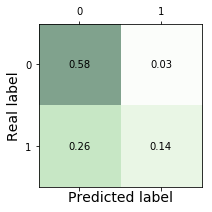

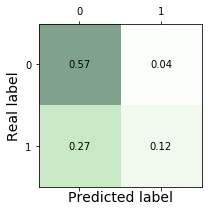

In [45]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [46]:
bagging_pipe = clone(best_bagging_pipe)
bagging_pipe.set_params(**{'clf__base_estimator__class_weight': {0: 1, 1: 1.4}})

bagging_pipe.fit(X_train, y_train);

y_train_pred = bagging_pipe.predict(X_train)
y_test_pred = bagging_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.759
Test dataset: accuracy = 0.704


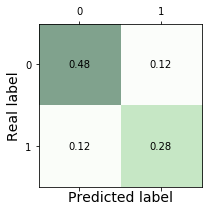

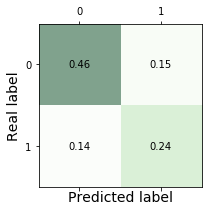

In [47]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [49]:
bagging_pipe_extended = clone(bagging_pipe)
bagging_pipe_extended.fit(X_extended, y_extended);

In [50]:
y_train_pred = bagging_pipe_extended.predict(X_extended)

In [51]:
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.751


In [52]:
file_name = 'baggingtree25.p'
model = bagging_pipe_extended
save_model(model, file_name)

#### Voting

In [184]:
estimators_list = [('dt', DecisionTreeClassifier(max_depth=10)),
                   ('lr', LogisticRegression(C=1., penalty='l2')),
                   ('rf', RandomForestClassifier(max_depth=10, max_features=0.5, n_estimators=10))]

voting_clf = VotingClassifier(estimators=estimators_list)

voting_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern,
                                                                    ngram_range=(1, 2)))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler()),
    ('clf', voting_clf)
])

param_grid = {'clf__voting': ['hard', 'soft'],
              'features__text_feats__vectorizer__min_df': [15, 25, 50]}

voting_gs = GridSearchCV(estimator=voting_pipe, param_grid=param_grid, 
                         cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), 
                         scoring='accuracy', 
                         n_jobs=-1, refit=True)

In [185]:
# voting_gs.fit(X_train, y_train);
# voting_gs.best_score_

In [ ]:
# voting_gs.best_params_

#### Boosting

In [197]:
?XGBClassifier

In [64]:
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [49]:
xgb_clf = XGBClassifier()

xgb_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern,
                                                                    ngram_range=(1, 2)))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler()),
    ('clf', xgb_clf)
])

param_dist = {'clf__learning_rate': uniform(0.001, 2 - 0.001),
              'clf__max_depth': randint(5, 20),
              'clf__reg_lambda': uniform(0, 2),
              'clf__gamma': uniform(0, 0.5),
              'clf__colsample_bytree': uniform(0.5, 0.5),
              'clf__subsample': uniform(0.5, 0.5),
              'clf__min_child_weight': randint(1, 11),
              'clf__n_estimators': randint(50, 400),
              'features__text_feats__vectorizer__min_df': randint(15, 50)
             }

xgb_rs = RandomizedSearchCV(estimator=xgb_pipe, param_distributions=param_dist, 
                            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=20), 
                            scoring='accuracy', n_iter=50,
                            n_jobs=-1, refit=True)

In [51]:
xgb_rs.fit(X_train, y_train);

In [63]:
xgb_rs.best_score_

0.8515967438948028

In [64]:
xgb_rs.best_params_

{'clf__colsample_bytree': 0.9898231977209171,
 'clf__gamma': 0.159422455552511,
 'clf__learning_rate': 0.13764196519734742,
 'clf__max_depth': 14,
 'clf__min_child_weight': 1,
 'clf__n_estimators': 263,
 'clf__reg_lambda': 1.7772772711792701,
 'clf__subsample': 0.5185253053361849,
 'features__text_feats__vectorizer__min_df': 15}

In [65]:
best_xgb_pipe = xgb_rs.best_estimator_

In [66]:
y_train_pred = best_xgb_pipe.predict(X_train)
y_test_pred = best_xgb_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.996
Test dataset: accuracy = 0.895


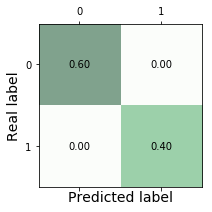

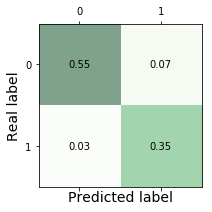

In [67]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

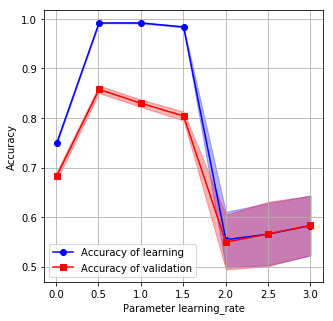

In [204]:
plot_validation_curve(estimator=clone(best_xgb_pipe), X=X_train, y=y_train, 
                      param_name='clf__learning_rate', param_range=np.linspace(0.01, 3, 7), x_scale='linear')

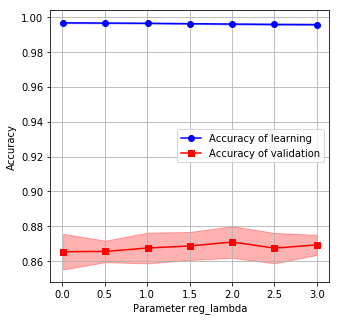

In [69]:
plot_validation_curve(estimator=clone(best_xgb_pipe), X=X_train, y=y_train, 
                      param_name='clf__reg_lambda', param_range=np.linspace(0.01, 3, 7), x_scale='linear')

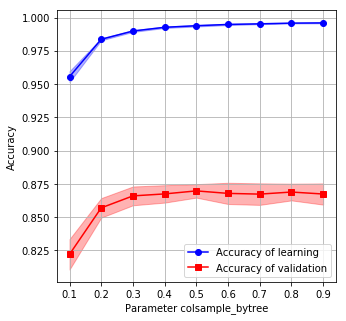

In [76]:
plot_validation_curve(estimator=clone(best_xgb_pipe), X=X_train, y=y_train, 
                      param_name='clf__colsample_bytree', param_range=np.linspace(0.1, 0.9, 9), x_scale='linear')

In [80]:
xgb_pipe = clone(best_xgb_pipe)
xgb_pipe.set_params(**{'clf__scale_pos_weight': 0.4,
                       'clf__colsample_bytree': 0.5
                      })

xgb_pipe.fit(X_train, y_train)

y_train_pred = xgb_pipe.predict(X_train)
y_test_pred = xgb_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.982
Test dataset: accuracy = 0.894


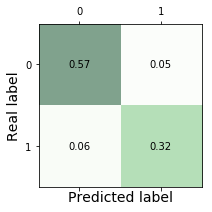

In [81]:
plot_confusion_matrix(y_test, y_test_pred)

In [82]:
xgb_pipe_extended = clone(xgb_pipe)
xgb_pipe_extended.fit(X_extended, y_extended);
y_extended_pred = xgb_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.983


In [83]:
file_name = 'xgb15.p'
model = xgb_pipe_extended
save_model(model, file_name)

In [65]:
xgb_clf = XGBClassifier()

xgb_select_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numerical_feats', FrequencyExtractor()),    
            ('text_feats', Pipeline([('preprocessor', TextPreprocessor(stopwords=IRRELEVANT_STOPWORDS, 
                                                                       process='stem')),
                                     ('vectorizer', CountVectorizer(token_pattern=token_pattern,
                                                                    ngram_range=(1, 2), min_df=2))
                                    ]))
            ])),
    ('scaler', MaxAbsScaler()),
    ('selector', SelectFpr(score_func=f_classif)),
    ('clf', xgb_clf)
])

param_dist = {'clf__learning_rate': uniform(0.001, 2 - 0.001),
              'clf__max_depth': randint(5, 20),
              'clf__reg_lambda': uniform(0, 2),
              'clf__gamma': uniform(0, 0.5),
              'clf__colsample_bytree': uniform(0.5, 0.5),
              'clf__subsample': uniform(0.5, 0.5),
              'clf__min_child_weight': randint(1, 11),
              'clf__n_estimators': randint(50, 400),
              'selector__alpha': uniform(0.01, 0.05)
             }

xgb_select_rs = RandomizedSearchCV(estimator=xgb_select_pipe, param_distributions=param_dist, 
                                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=20), 
                                   scoring='accuracy', n_iter=20,
                                   n_jobs=-1, refit=True)

In [66]:
xgb_select_rs.fit(X_train, y_train);

In [67]:
xgb_select_rs.best_score_

0.823888541014402

In [68]:
xgb_select_rs.best_params_

{'clf__colsample_bytree': 0.742098897747156,
 'clf__gamma': 0.06093359081230881,
 'clf__learning_rate': 0.6044594618527709,
 'clf__max_depth': 10,
 'clf__min_child_weight': 5,
 'clf__n_estimators': 247,
 'clf__reg_lambda': 0.2764503698469625,
 'clf__subsample': 0.9522617111323792,
 'selector__alpha': 0.026982149145027758}

In [69]:
best_xgb_pipe = xgb_select_rs.best_estimator_

In [70]:
y_train_pred = best_xgb_pipe.predict(X_train)
y_test_pred = best_xgb_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.991
Test dataset: accuracy = 0.865


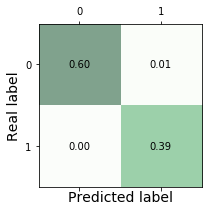

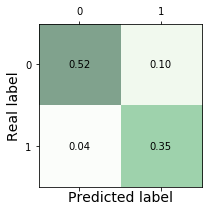

In [71]:
plot_confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(y_test, y_test_pred)

In [123]:
xgb_pipe = clone(best_xgb_pipe)
xgb_pipe.set_params(**{'clf__scale_pos_weight': 0.4,
                       'clf__colsample_bytree': 0.5,
#                        'selector__alpha': 0.05,
                       'clf__reg_lambda': 2.,
#                        'clf__learning_rate': 0.8,
                       'clf__max_depth': 50
                      })

xgb_pipe.fit(X_train, y_train)

y_train_pred = xgb_pipe.predict(X_train)
y_test_pred = xgb_pipe.predict(X_test)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_train_pred, y_true=y_train))
print('Test dataset: accuracy = %.3f' % accuracy_score(y_pred=y_test_pred, y_true=y_test))

Tarining dataset: accuracy = 0.987
Test dataset: accuracy = 0.879


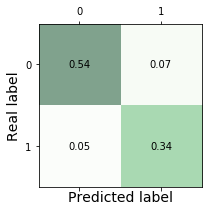

In [124]:
plot_confusion_matrix(y_test, y_test_pred)

In [125]:
xgb_pipe_extended = clone(xgb_pipe)
xgb_pipe_extended.fit(X_extended, y_extended);
y_extended_pred = xgb_pipe_extended.predict(X_extended)
print('Tarining dataset: accuracy = %.3f' % accuracy_score(y_pred=y_extended_pred, y_true=y_extended))

Tarining dataset: accuracy = 0.988


In [126]:
file_name = 'xgbselect.p'
model = xgb_pipe_extended
save_model(model, file_name)

### Recurrent Neural Network

In [172]:
from mytextpreprocessing import WordToIndexTransformer

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, LSTM, Bidirectional
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import print_summary

In [204]:
preprocessor = TextPreprocessor(stopwords=[], process='stem')
wordToIndex = WordToIndexTransformer(preprocessor)

In [205]:
X_rnn_train = wordToIndex.fit_transform(X_train)
X_rnn_test = wordToIndex.transform(X_test)

In [206]:
file_name = 'wordToIndex.p'
save_model(wordToIndex, file_name)

In [207]:
max_features = wordToIndex.unique_words_no + 1
maxlen = wordToIndex.maxlen
embedding_dims = 32
print(max_features, maxlen)

10867 280


In [208]:
X_rnn_train.shape, X_rnn_test.shape

((12776, 280), (3194, 280))

In [174]:
X_rnn_extended = wordToIndex.fit_transform(X_extended)

In [202]:
file_name = 'wordToIndex.p'
save_model(wordToIndex, file_name)

In [175]:
max_features = wordToIndex.unique_words_no + 1
maxlen = wordToIndex.maxlen
embedding_dims = 32
print(max_features, maxlen)

11982 280


In [176]:
X_rnn_extended.shape

(15970, 280)

In [245]:
model = Sequential()
model.add(Embedding(max_features, embedding_dims, input_length=maxlen))
# model.add(SimpleRNN(50, return_sequences=False))
# model.add(LSTM(30, return_sequences=False))
# model.add(Bidirectional(SimpleRNN(30, return_sequences=True)))
model.add(Bidirectional(SimpleRNN(10, return_sequences=False)))
model.add(Dropout(0.5))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.002)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [246]:
print_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 280, 32)           347744    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 20)                860       
_________________________________________________________________
dropout_10 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 21        
Total params: 348,625
Trainable params: 348,625
Non-trainable params: 0
_________________________________________________________________


In [247]:
early_stopping = EarlyStopping(patience=1)

# model.fit(X_rnn_extended, y_extended, batch_size=32, epochs=30, callbacks=[early_stopping], validation_split=0.5)

model.fit(X_rnn_train, y_train, validation_data=(X_rnn_test, y_test), 
          batch_size=32, epochs=3, callbacks=[early_stopping])

Train on 12776 samples, validate on 3194 samples
Epoch 1/3
12776/12776 [==============================] - 55s 4ms/step - loss: 0.6348 - acc: 0.6311 - val_loss: 0.5778 - val_acc: 0.6919
Epoch 2/3
12776/12776 [==============================] - 55s 4ms/step - loss: 0.4894 - acc: 0.7779 - val_loss: 0.4701 - val_acc: 0.7912
Epoch 3/3
12776/12776 [==============================] - 55s 4ms/step - loss: 0.3170 - acc: 0.8886 - val_loss: 0.4136 - val_acc: 0.8172


In [248]:
train_accuracy = model.evaluate(X_rnn_train, y_train, verbose=0)
test_accuracy = model.evaluate(X_rnn_test, y_test, verbose=0)

print('Tarining dataset:\nloss = %.3f\naccuracy = %.3f' % tuple(train_accuracy))
print('Test dataset:\nloss = %.3f\naccuracy = %.3f' % tuple(test_accuracy))

Tarining dataset:
loss = 0.175
accuracy = 0.954
Test dataset:
loss = 0.414
accuracy = 0.817


In [ ]:
# model.fit(X_rnn_extended, y_extended, batch_size=32, epochs=6)

In [221]:
# train_accuracy = model.evaluate(X_rnn_extended, y_extended, verbose=0)
# print('Tarining dataset:\nloss = %.3f\naccuracy = %.3f' % tuple(train_accuracy))

In [46]:
y_extended_proba = model.predict(X_rnn_extended)[:, 0]
y_extended_pred = np.where(y_extended_proba >= 0.5, 1, 0)

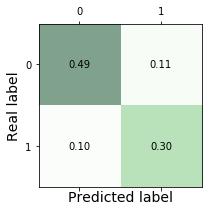

In [47]:
plot_confusion_matrix(y_extended, y_extended_pred)

In [244]:
file_name = 'bi30rnn.h5'
models_path = 'Models'
model.save(os.path.join(models_path, file_name))